# Similarity analysis

We want to determine if the different batch simulated data is able to capture the biological signal that is present in the original data:  How much of the real input data is captured in the simulated batch data?

In other words, we want to ask: “do these datasets have similar patterns”?

To do this we will use a visual inspection using PCA

**Approach:**
1. Given Dataset A = simulated data with everything in 1 batch and Dataset B = simulated data with X batches, where X = 1,2,3,....
2. Plot PC1 vs PC2 of combined dataset A + B
3. Color samples by whether they are from A or B
4. Visually inspect the overlap between A and B

In [1]:
%load_ext autoreload
%autoreload 2

import os
import ast
import pandas as pd
import numpy as np
import random
import glob
from plotnine import *
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Load config file
config_file = "config_exp_2.txt"

d = {}
float_params = ["learning_rate", "kappa", "epsilon_std"]
str_params = ["analysis_name", "NN_architecture"]
lst_params = ["num_batches"]
with open(config_file) as f:
    for line in f:
        (name, val) = line.split()
        if name in float_params:
            d[name] = float(val)
        elif name in str_params:
            d[name] = str(val)
        elif name in lst_params:
            d[name] = ast.literal_eval(val)
        else:
            d[name] = int(val)

In [3]:
# Parameters
analysis_name = d["analysis_name"]
NN_architecture = d["NN_architecture"]
num_batches = d["num_batches"]

In [4]:
# Load data
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../.."))

batch_dir = os.path.join(
    base_dir,
    "data",
    "batch_simulated",
    analysis_name)

Plotting PCA of 1 batch vs 1 batches...
(12000, 5001)


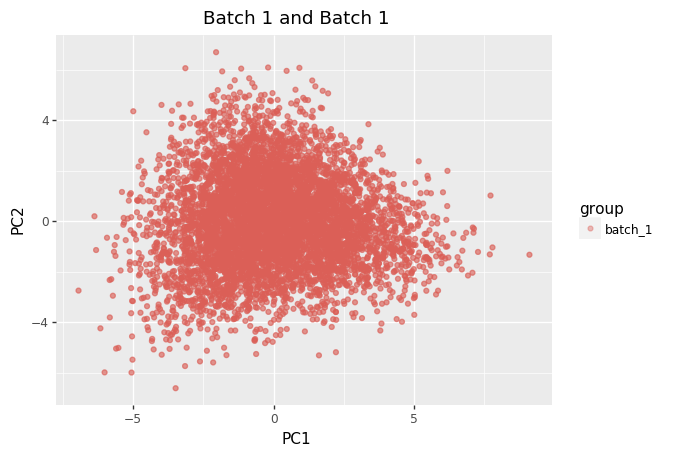

<ggplot: (-9223363245955923887)>
Plotting PCA of 1 batch vs 2 batches...
(12000, 5001)


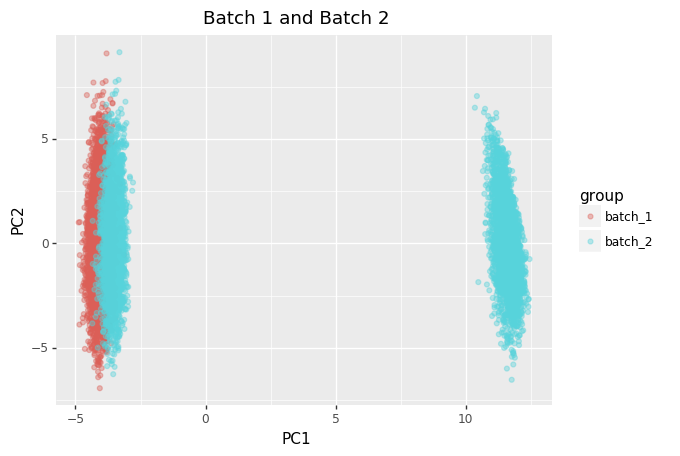

<ggplot: (8790898152575)>
Plotting PCA of 1 batch vs 5 batches...
(12000, 5001)


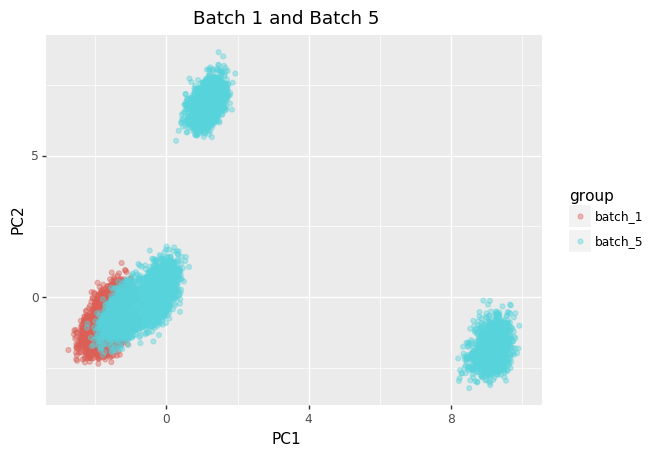

<ggplot: (8790898342236)>
Plotting PCA of 1 batch vs 10 batches...
(12000, 5001)


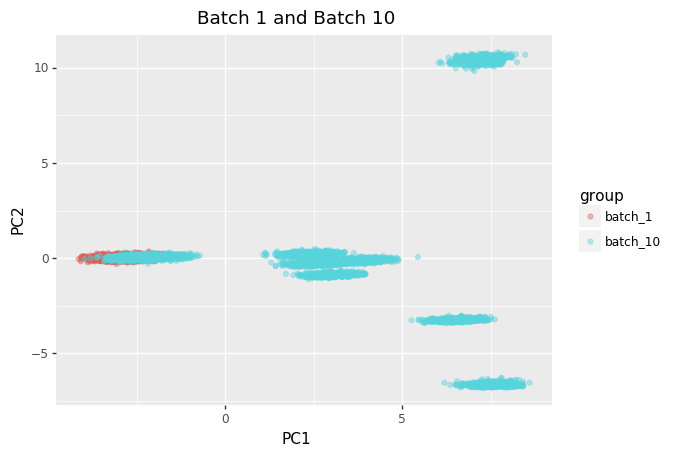

<ggplot: (-9223363245959074893)>
Plotting PCA of 1 batch vs 20 batches...
(12000, 5001)


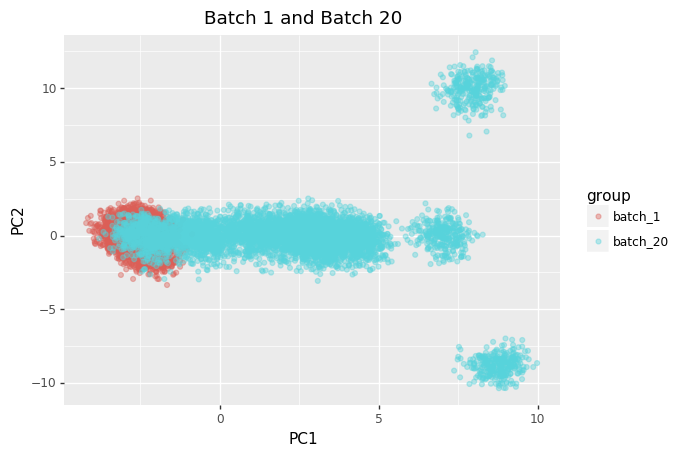

<ggplot: (-9223363245959148712)>
Plotting PCA of 1 batch vs 50 batches...
(12000, 5001)


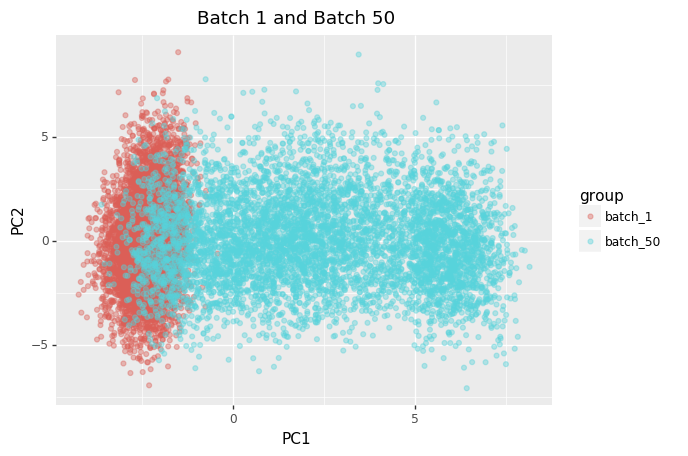

<ggplot: (8790942042481)>
Plotting PCA of 1 batch vs 100 batches...
(12000, 5001)


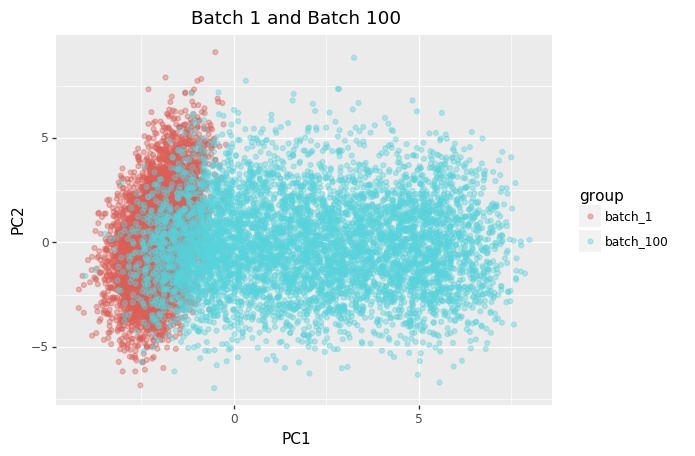

<ggplot: (8790894831322)>
Plotting PCA of 1 batch vs 500 batches...
(12000, 5001)


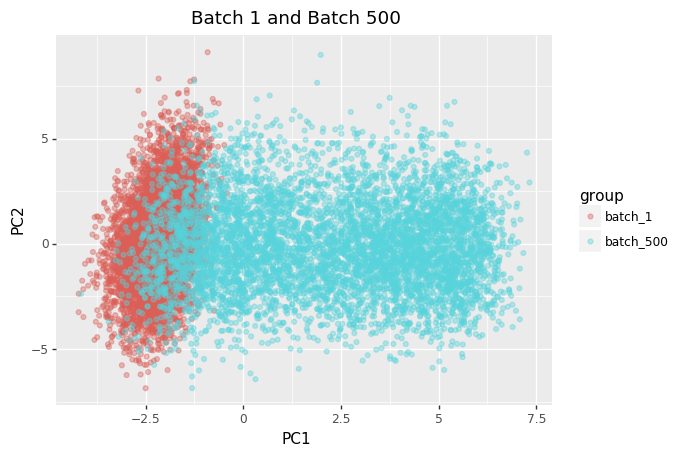

<ggplot: (8790894591429)>
Plotting PCA of 1 batch vs 1000 batches...
(12000, 5001)


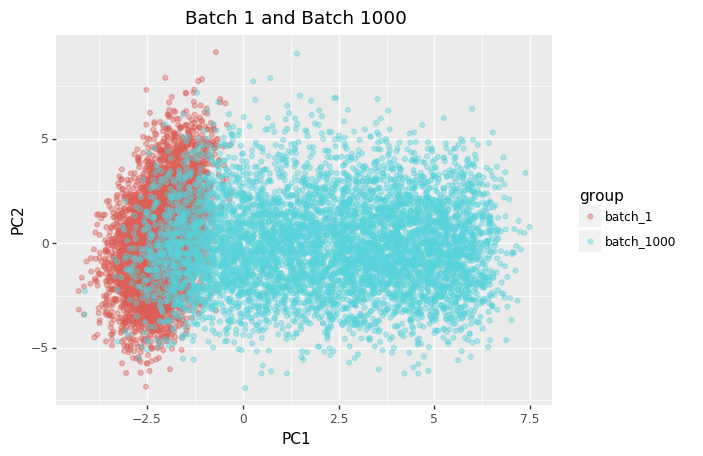

<ggplot: (-9223363245960184334)>
Plotting PCA of 1 batch vs 2000 batches...
(12000, 5001)


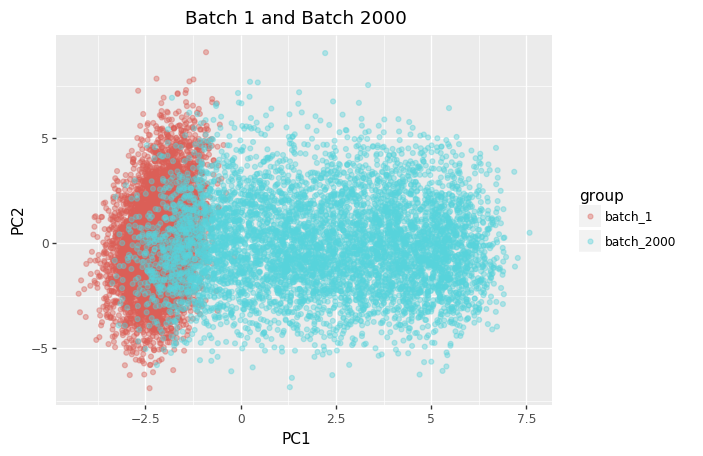

<ggplot: (8790941944142)>
Plotting PCA of 1 batch vs 3000 batches...
(12000, 5001)


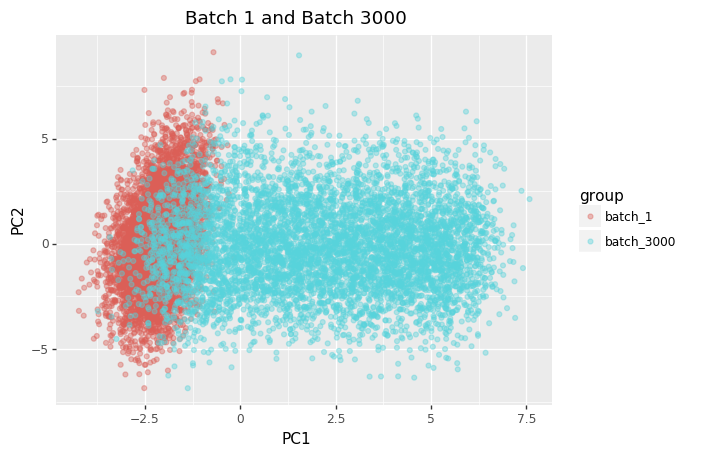

<ggplot: (-9223363245959942887)>
Plotting PCA of 1 batch vs 6000 batches...
(12000, 5001)


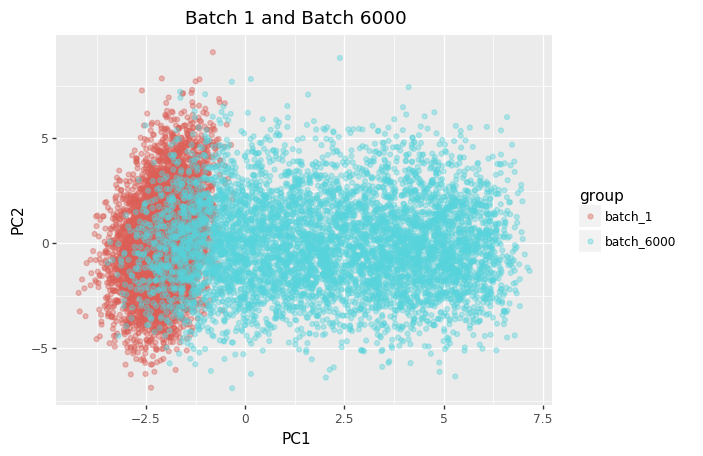

<ggplot: (8790894031592)>
CPU times: user 7min 50s, sys: 38.7 s, total: 8min 29s
Wall time: 7min 47s


In [5]:
%%time

all_data_df = pd.DataFrame()

for i in num_batches:
    print('Plotting PCA of 1 batch vs {} batches...'.format(i))
    
    # Get batch 1 data
    batch_1_file = os.path.join(
        batch_dir,
        "Batch_1.txt.xz")

    batch_1 = pd.read_table(
        batch_1_file,
        header=0,
        index_col=0,
        sep='\t')

    # Simulated data with all samples in a single batch
    original_data_df =  batch_1
    
    # Add grouping column for plotting
    original_data_df['group'] = 'batch_1'
    
    # Get data with additional batch effects added
    batch_other_file = os.path.join(
        batch_dir,
        "Batch_"+str(i)+".txt.xz")

    batch_other = pd.read_table(
        batch_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    batch_data_df =  batch_other
    
    # Add grouping column for plotting
    batch_data_df['group'] = "batch_{}".format(i)
    
    ## Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, batch_data_df])
    print(combined_data_df.shape)
    
    ## PCA projection
    pca = PCA(n_components=2)

    # Use trained model to encode expression data into SAME latent space
    combined_data_numeric_df = combined_data_df.drop(['group'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add batch labels for the dataset that each sample belongs to (i.e. how many batches were added)
    combined_data_PCAencoded_df['group'] = combined_data_df['group']
    
    # Add column that designates which Batch effect comparision
    combined_data_PCAencoded_df['num_batches'] = str(i)
    
    # Concatenate all dataframes from each batch effect together
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])
    
    
    # Plot
    print(ggplot(combined_data_PCAencoded_df, aes(x='PC1', y='PC2')) \
          + geom_point(aes(color='group'), alpha=0.4) \
          + xlab('PC1') \
          + ylab('PC2') \
          + ggtitle('Batch 1 and Batch {}'.format(i))
         )

In [20]:
# Permute simulated data
shuffled_simulated_arr = []
num_samples = batch_1.drop(['group']).shape[0]

for i in range(num_samples):
    row = list(batch_1.values[i])
    shuffled_simulated_row = random.sample(row, len(row))
    shuffled_simulated_arr.append(shuffled_simulated_row)

shuffled_simulated_data = pd.DataFrame(shuffled_simulated_arr, 
                                       index=batch_1.index,
                                       columns=batch_1.drop(['group']).columns)
shuffled_simulated_data.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2526,3299,3097,5330,2854,494,5089,3662,1920,group
0,0.333940,0.302232,0.487451,0.553286,0.375819,0.244265,0.270555,0.137153,0.411099,0.603559,...,0.541866,0.252235,0.376616,0.280557,0.253236,0.254919,0.289947,0.425219,0.729971,0.368212
1,0.447524,0.563154,0.411684,0.136897,0.407113,0.621294,0.333491,0.778847,0.635101,0.537128,...,0.658684,0.303906,0.507916,0.749103,0.415569,0.404262,0.155043,0.132924,0.462429,0.139603
2,0.239766,0.626255,0.317164,0.335919,0.3207,0.346837,0.454506,0.224412,0.381701,0.434724,...,0.160003,0.665171,0.399506,0.0810049,0.598791,0.455215,0.583848,0.203779,0.252711,0.389492
3,0.400341,0.540419,0.559733,0.552356,0.500531,0.341774,0.388649,0.188448,0.44451,0.183650,...,0.46663,0.592349,0.444597,0.299648,0.393934,0.354656,0.399139,0.269876,0.477984,0.549092
4,0.200307,0.290962,0.342682,0.192392,0.388139,0.214045,0.495308,0.585925,0.465947,0.436465,...,0.527411,0.415311,0.255554,0.71301,0.285926,0.383608,0.521249,0.469753,0.374743,0.327529


In [22]:
batch_1.head()

,5340,339,244,1567,1827,4981,2310,3929,1498,3226,...,2526,3299,3097,5330,2854,494,5089,3662,1920,group
0,0.535602,0.503128,0.285015,0.182251,0.338972,0.563961,0.324290,0.469941,0.185681,0.090720,...,0.256521,0.326031,0.611043,0.412167,0.438068,0.280573,0.609067,0.402821,0.158164,batch_1
1,0.602998,0.314449,0.170274,0.150126,0.393875,0.425789,0.359611,0.367097,0.162651,0.060858,...,0.284270,0.290870,0.574704,0.281427,0.427374,0.250592,0.675274,0.470036,0.133792,batch_1
2,0.517498,0.419739,0.182155,0.131460,0.324510,0.413850,0.320531,0.416758,0.152202,0.088437,...,0.273688,0.418673,0.734889,0.254353,0.468174,0.249746,0.694683,0.476522,0.128183,batch_1
3,0.397841,0.457606,0.323778,0.249936,0.297673,0.476715,0.381297,0.468330,0.215541,0.132116,...,0.380182,0.329754,0.520238,0.422373,0.406375,0.207356,0.601750,0.407103,0.174844,batch_1
4,0.535997,0.465947,0.277286,0.222062,0.385123,0.421842,0.330086,0.415129,0.177301,0.128083,...,0.298452,0.395627,0.590282,0.290962,0.399933,0.272622,0.597588,0.440435,0.206779,batch_1


In [21]:
# PCA of permuted dataset (Negative control)
shuffled_data_PCAencoded = pca.fit_transform(shuffled_simulated_data)


shuffled_data_PCAencoded_df = pd.DataFrame(shuffled_data_PCAencoded,
                                           index=shuffled_simulated_data.index,
                                           columns=['PC1', 'PC2']
                                          )

# Add batch labels for the dataset that each sample belongs to (i.e. how many batches were added)
shuffled_data_PCAencoded_df['group'] = "permuted"

# Add column that designates which Batch effect comparision
shuffled_data_PCAencoded_df['num_batches'] = "permuted"

# Add to dataframe
all_data_df = pd.concat([all_data_df, shuffled_data_PCAencoded_df])

ValueError: could not convert string to float: 'batch_1'

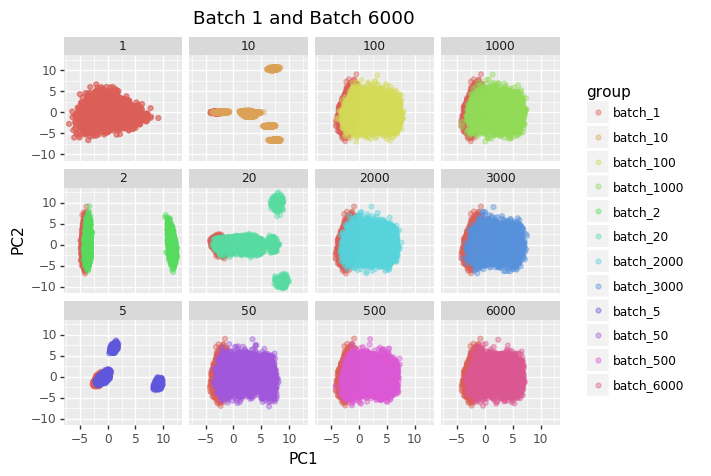

<ggplot: (8790898589360)>

In [9]:
# Plot
ggplot(all_data_df, aes(x='PC1', y='PC2')) \
+ geom_point(aes(color='group'), alpha=0.3) \
+ facet_wrap('~num_batches') \
+ xlab('PC1') \
+ ylab('PC2') \
+ ggtitle('Batch 1 and Batch {}'.format(i))